In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# download nc files based on URL and patch together
# https://www.ngdc.noaa.gov/thredds/catalog/global/ETOPO2022/15s/15s_geoid_netcdf/catalog.html?dataset=globalDatasetScan/ETOPO2022/15s/15s_geoid_netcdf/ETOPO_2022_v1_15s_N00E000_geoid.nc#:~:text=the%20DAP2%20protcol.-,HTTPServer,-Data%20Access

In [16]:
import requests
from bs4 import BeautifulSoup
from pathlib import Path
import urllib
import xarray as xa
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd

In [4]:
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url: str, output_path: Path | str, loading_bar: bool = True) -> None:
    print('\n')
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=Path(output_path), reporthook=t.update_to)

In [5]:
def get_n_last_subparts_path(dir_path: Path | str, n: int) -> Path:
    """Returns 'n'  last parts of a path. E.g. /first/second/third/fourth with n = 3 will return second/third/fourth"""
    return Path(*Path(dir_path).parts[-n:])


def check_path_suffix(path: Path | str, comparison: str) -> bool:
    """Checks whether path provided ends in a particular suffix e.g. "nc". Since usually forget to specify ".", first
    tries to pad "comparison" with a period. TODO: docstring"""

    # pad with leading "."
    if "." not in comparison:
        comparison = "." + comparison

    if Path(path).suffix == comparison:
        return True
    else:
        return False


def download_etopo_data(download_dest_dir: Path | str, resolution: str | int) -> None:
    """Download data"""
    bathymetry_url_page = f"https://www.ngdc.noaa.gov/thredds/catalog/global/ETOPO2022/{resolution}s/{resolution}s_geoid_netcdf/catalog.html"
    file_server_url = "https://www.ngdc.noaa.gov/thredds/fileServer/global/"

    reqs = requests.get(bathymetry_url_page)
    soup = BeautifulSoup(reqs.text, 'html.parser')

    # traverse paragraphs from soup TODO: add progress bar
    for link in soup.find_all("a"):
        # if ends with nc
        if check_path_suffix(link.get("href"), "nc"):
            file_specifier = get_n_last_subparts_path(Path(link.get("href")), 4)
            file_name = get_n_last_subparts_path(Path(link.get("href")), 1)

            # download file TODO: put this into a function (including checking if already exists)
            r = requests.get(file_server_url + str(file_specifier))
            # with open(Path(download_dest_dir, file_name), 'wb') as f:
                # copypasted something over and lost this line...


def check_path_suffix(path: Path | str, comparison: str) -> bool:
    """Checks whether path provided ends in a particular suffix e.g. "nc". Since usually forget to specify ".", first
    tries to pad "comparison" with a period. TODO: docstring"""

    # pad with leading "."
    if "." not in comparison:
        comparison = "." + comparison

    if Path(path).suffix == comparison:
        return True
    else:
        return False


def download_etopo_data(download_dest_dir: Path | str, resolution: str | int) -> None:
    """Download data"""
    bathymetry_url_page = f"https://www.ngdc.noaa.gov/thredds/catalog/global/ETOPO2022/{resolution}s/{resolution}s_geoid_netcdf/catalog.html"
    file_server_url = "https://www.ngdc.noaa.gov/thredds/fileServer/global/"

    reqs = requests.get(bathymetry_url_page)
    soup = BeautifulSoup(reqs.text, 'html.parser')

    # traverse paragraphs from soup TODO: add progress bar
    for link in soup.find_all("a"):
        # if ends with nc
        if check_path_suffix(link.get("href"), "nc"):
            file_specifier = get_n_last_subparts_path(Path(link.get("href")), 4)
            file_name = get_n_last_subparts_path(Path(link.get("href")), 1)

            # download file TODO: put this into a function (including checking if already exists)
            r = requests.get(file_server_url + str(file_specifier))
            with open(Path(download_dest_dir, file_name), 'wb') as f:
                f.write(r.content)
            # print(file_specifier)


def load_merge_nc_files(nc_dir: Path | str):
    files = Path(nc_dir).glob("*.nc")
    # combine nc files by coordinates
    merged_ncs = xa.open_mfdataset(files)


In [6]:
# this is VERY hacky: but couldn't figure out how to scrape links from buttons: there seems to be no hmtl which
# differentiates one button from another...

def check_exists_download_url(filepath: Path | str, url : str, loading_bar: bool = True) -> None:
	"""Download file from URL, with choice of loading bar to show download progress"""

	# if not downloaded
	if not Path(filepath).is_file():
		# download with loading bar
		if loading_bar:
			download_url(url, str(filepath))
		# download without loading bar for some reason...
		else:
			urllib.request.urlretrieve(url, filename=output_path)
	# if already downloaded
	else:
		print(f'Already exists: {filepath}')
	
    

def download_30m_gbr_bathymetry(download_dest_dir: Path | str, areas: list[str]) -> None:
    # start_data_url = "https://ausseabed-public-warehouse-bathymetry.s3.ap-southeast-2.amazonaws.com/L3/0b9ad3f3-7ade-40a7-ae70-f7c6c0f3ae2e/"

    data_urls = ["https://ausseabed-public-warehouse-bathymetry.s3.ap-southeast-2.amazonaws.com/L3/0b9ad3f3-7ade-40a7-ae70-f7c6c0f3ae2e/Great_Barrier_Reef_A_2020_30m_MSL_cog.tif",
        "https://ausseabed-public-warehouse-bathymetry.s3.ap-southeast-2.amazonaws.com/L3/4a6e7365-d7b1-45f9-a576-2be8ff8cd755/Great_Barrier_Reef_B_2020_30m_MSL_cog.tif",
        "https://ausseabed-public-warehouse-bathymetry.s3.ap-southeast-2.amazonaws.com/L3/3b171f8d-9248-4aeb-8b32-0737babba3c2/Great_Barrier_Reef_C_2020_30m_MSL_cog.tif",
        "https://ausseabed-public-warehouse-bathymetry.s3.ap-southeast-2.amazonaws.com/L3/7168f130-f903-4f2b-948b-78508aad8020/Great_Barrier_Reef_D_2020_30m_MSL_cog.tif"
        ]

    for area_url in list(data_urls):
        area_filename = get_n_last_subparts_path(area_url, 1)
        # area_filename = f"Great_Barrier_Reef_{alpha.upper()}_2020_30m_MSL_cog.tif"
        # area_url = '/'.join((start_data_url, area_filename))

        filepath = Path(download_dest_dir, area_filename)
        # check whether file already downloaded
        check_exists_download_url(filepath, area_url)
		
		# if not filepath.is_file():
        #     # if not downloaded, downloaded
        #     download_url(area_url, str(filepath))
        # else:
        #     print(f'{filepath} already exists.')

In [7]:
# import urllib.request
# from rich.progress import Progress, BarColumn, DownloadColumn, TransferSpeedColumn, TimeRemainingColumn


# class DownloadProgressBar:
#     def __init__(self, unit='B'):
#         self.progress = Progress(
#             "{task.description}",
#             BarColumn(),
#             DownloadColumn(),
#             TransferSpeedColumn(),
#             TimeRemainingColumn(),
#         )
#         self.unit = unit

#     def __enter__(self):
#         self.task_id = self.progress.add_task("", start=False)
#         self.progress.start()
#         return self

#     def __exit__(self, *exc_info):
#         self.progress.stop()

#     def update_to(self, b=1, bsize=1, tsize=None):
#         if tsize is not None:
#             # Convert the total size to the specified unit
#             total_size = tsize / self.unit_size
#             self.progress.update(self.task_id, total=total_size)
#         self.progress.update(self.task_id, advance=b * bsize / self.unit_size)

#     @property
#     def unit_size(self):
#         # Return the size of one unit in bytes
#         if self.unit == 'B':
#             return 1
#         elif self.unit == 'KB':
#             return 1024
#         elif self.unit == 'MB':
#             return 1024 * 1024
#         elif self.unit == 'GB':
#             return 1024 * 1024 * 1024
#         else:
#             raise ValueError(f"Invalid unit: {self.unit}")

# def download_url(url, output_path, progress_units: str = 'MB'):
#     print("\n")
#     with DownloadProgressBar(progress_units) as t:
#         urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)


In [8]:
download_30m_gbr_bathymetry(
	'/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/GBR_30m', 
	areas = ['a','b','c','d'])

Already exists: /Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/GBR_30m/Great_Barrier_Reef_A_2020_30m_MSL_cog.tif
Already exists: /Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/GBR_30m/Great_Barrier_Reef_B_2020_30m_MSL_cog.tif
Already exists: /Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/GBR_30m/Great_Barrier_Reef_C_2020_30m_MSL_cog.tif
Already exists: /Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/GBR_30m/Great_Barrier_Reef_D_2020_30m_MSL_cog.tif


In [5]:
# read tif
import rasterio

src = rasterio.open('/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/GBR_30m/Great_Barrier_Reef_A_2020_30m_MSL_cog.tif')
gbr_a_data = src.read(1)

In [10]:
def open_tifs_to_dict(tif_paths: list[Path] | list[str]) -> dict:
	"""TODO: docstring"""

	tifs_dict = {}
	for tif in tif_paths:
		filename = get_n_last_subparts_path(tif, 1)
		tif_src = rasterio.open(tif)
		tif_array = tif_src.read(1)

		tifs_dict[filename] = tif_array

	return tifs_dict

KeyboardInterrupt: 

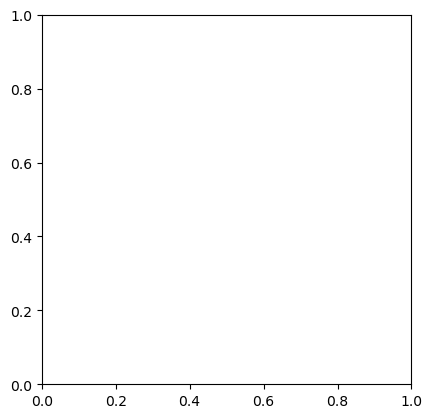

In [11]:
# plt.imshow(gbr_a_data[0:10000, 0:10000])
plt.imshow(gbr_a_data)
plt.show()

In [28]:
binary = np.isclose(data_array[0], 0, atol=0.5)

In [46]:
sum(sum(binary))

424188

In [33]:
from scipy.ndimage import binary_dilation

# Perform a morphological dilation operation
buffer_size = 10  # Define the buffer size
struct_elem = np.ones((buffer_size, buffer_size))  # Define the structuring element
dilated = binary_dilation(binary, iterations=buffer_size)

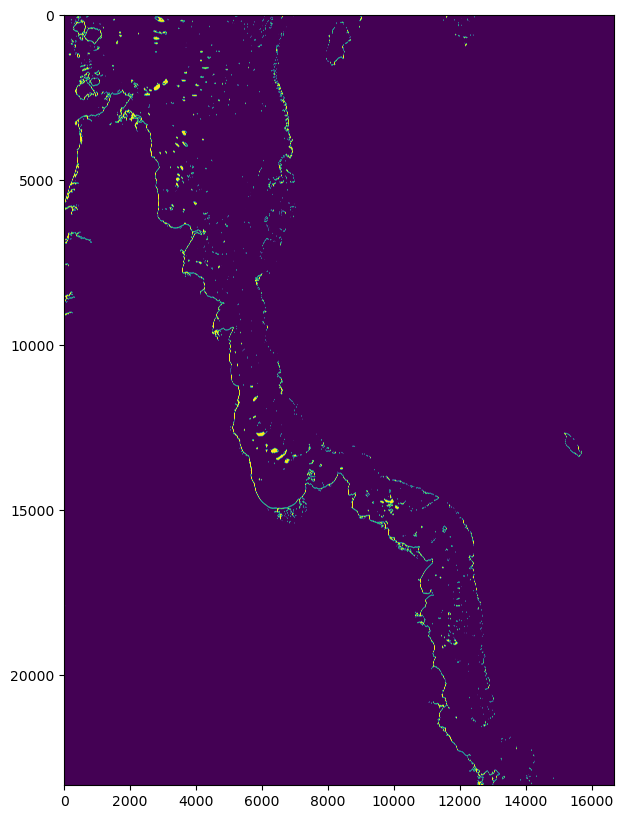

In [34]:
plt.figure(figsize = (15,10))
plt.imshow(dilated)

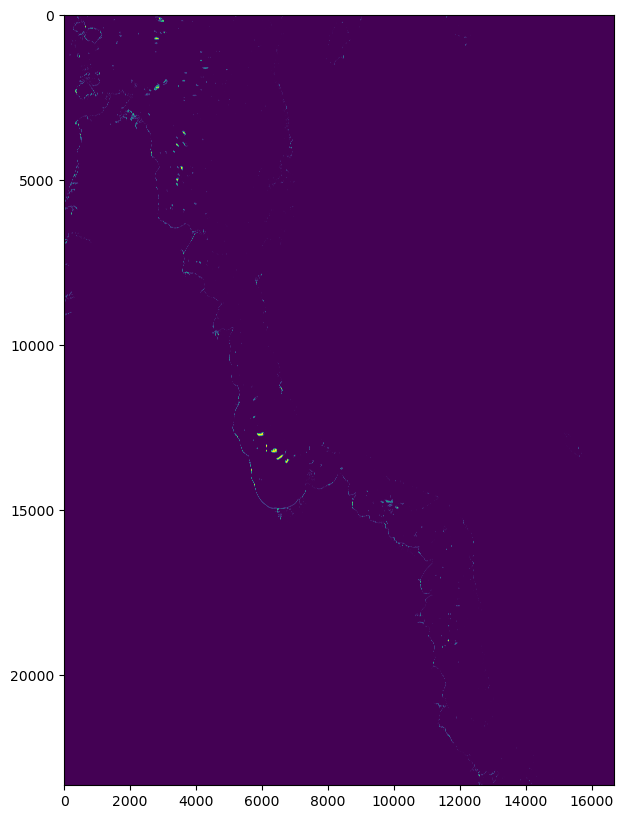

In [25]:
plt.figure(figsize = (15,10))
plt.imshow(shoreline)

In [70]:
# function to return pixel values closest to the shoreline
def return_pixels_closest_to_value(
	array: np.array, 
	central_value: float, 
	tolerance: float = .5, 
	buffer_pixels: int = 10,
	bathymetry_only: bool = True
	) -> np.array:
	"""TODO: docstring"""
	binary = np.isclose(array, central_value, atol=0.5)
	# morphological dilation operation
	dilated = binary_dilation(binary, iterations=buffer_pixels)

	array_vals = array[dilated]
	# if specifying only bathymetric data
	if bathymetry_only:
		array_vals = array_vals[array_vals < 0]
	
	# return only non-zero values as 1d array
	return array_vals[np.nonzero(array_vals)]


def return_distance_closest_to_value(
	array: np.array, 
	central_value: float, 
	tolerance: float = .5, 
	buffer_distance: int = 300,
	distance_per_pixel: float = 30,
	bathymetry_only: bool = True,
) -> np.array:
	"""Wrapper for return_pixels_closest_to_value() allowing specification by distance from thresholded values rather 
	than number of pixels"""
	buffer_pixels = buffer_distance / distance_per_pixel
	return return_pixels_closest_to_value(array, central_value, tolerance, buffer_pixels, bathymetry_only)

In [71]:
out = return_pixels_closest_to_value(data_array[0].values, 0, buffer_pixels=1)

In [72]:
out
shallow_out = out[out > -100]

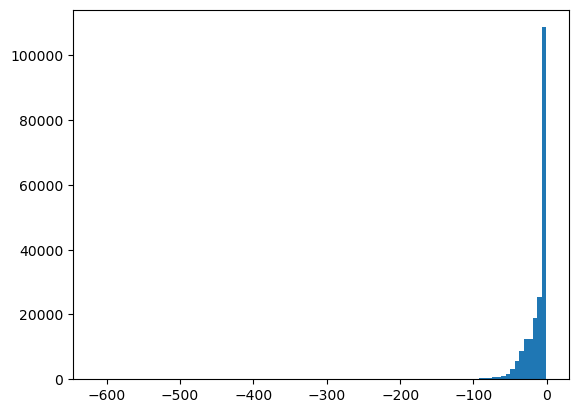

In [73]:
plt.hist(out,100);

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

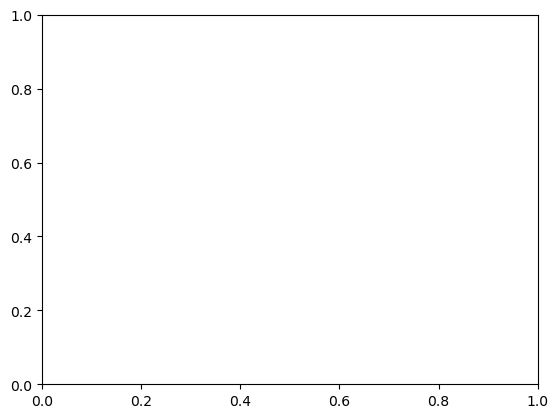

In [58]:
# function to plot histogram of values

fig, ax = plt.subplots()
xa.plot.hist(data_array, ax=ax, bins=100)
ax.set_xlabel("depth")
ax.set_ylabel("counts")
ax.set_title("Histogram of DEM counts for selected area")

In [ ]:
src.crs

In [8]:
data_array = xa.open_rasterio(src)

/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_56675/2606527976.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  data_array = xa.open_rasterio(src)


In [14]:
data_array[0]
# rename coordinate and value fields

<xarray.DataArray (y: 23333, x: 16666)>
[388867778 values with dtype=float32]
Coordinates:
    band     int64 1
  * y        (y) float64 -10.0 -10.0 -10.0 -10.0 ... -17.0 -17.0 -17.0 -17.0
  * x        (x) float64 142.0 142.0 142.0 142.0 ... 147.0 147.0 147.0 147.0
Attributes:
    transform:      (0.0002999999999999996, 0.0, 142.0000611111, 0.0, -0.0003...
    crs:            +init=epsg:4326
    res:            (0.0002999999999999996, 0.0003000000000000001)
    is_tiled:       1
    nodatavals:     (-9999.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [30]:
new_name_dict = {'y': 'latitude', 'x': 'longitude'}

data_array = data_array.rename(new_name_dict)

In [31]:
data_array[0, 0:5000, 0:5000]

<xarray.DataArray (latitude: 5000, longitude: 5000)>
[25000000 values with dtype=float32]
Coordinates:
    band       int64 1
  * latitude   (latitude) float64 -10.0 -10.0 -10.0 -10.0 ... -11.5 -11.5 -11.5
  * longitude  (longitude) float64 142.0 142.0 142.0 142.0 ... 143.5 143.5 143.5
Attributes:
    transform:      (0.0002999999999999996, 0.0, 142.0000611111, 0.0, -0.0003...
    crs:            +init=epsg:4326
    res:            (0.0002999999999999996, 0.0003000000000000001)
    is_tiled:       1
    nodatavals:     (-9999.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [1]:
## module import error
import gdal
# ds = gdal.Open('/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/GBR_30m/Great_Barrier_Reef_A_2020_30m_MSL_cog.tif')
# channel = np.array(ds.GetRasterBand(1).ReadAsArray())

ModuleNotFoundError: No module named 'gdal'

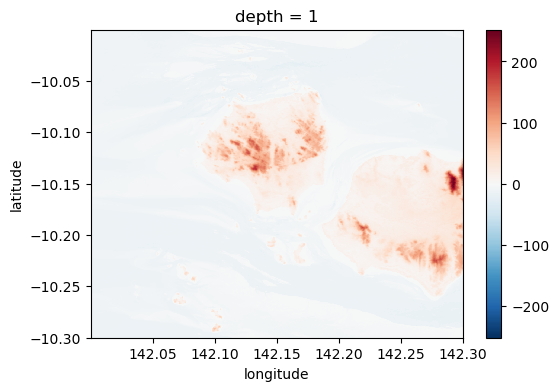

In [27]:
data_array[0, :1000, :1000].plot(x='longitude', y='latitude', figsize=(6,4))

In [ ]:
# df = data_array[0].to_dataframe(name='asdf').reset_index()
# gdf = gpd.GeoDataFrame(df.value_column, geometry=gpd.points_from_xy(df.y,df.x))


In [ ]:
plot.gdf()

In [ ]:
def align_tifs_to_worldmap(tifs_dict: dict) -> gpd.GeoDataFrame:
	"""TODO: docstring"""
	
	gdf_list = []
	for tif_name, tif_array in tifs_dict:
		bbox_gdf = align_tifs_to_worldmap(tif_array)
		gdf_list.append(bbox_gdf)

	all_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs=gdf_list[0].crs)	
	return all_gdf


def align_tifs_to_worldmap(tif_object) -> gpd.GeoDataFrame:
	"""TODO: function to line tif files up with world map"""

	# Create GeoDataFrame with extent of the raster
	xmin, ymin, xmax, ymax = tif_object.bounds
	bbox_gdf = gpd.GeoDataFrame({'geometry': gpd.box(xmin, ymin, xmax, ymax)}, index=[0], crs=tif_object.crs)

	# Reproject the GeoDataFrame to Web Mercator
	bbox_gdf = bbox_gdf.to_crs(epsg=3857)

	return bbox_gdf



In [ ]:
align_tifs_to_worldmap(src)

In [ ]:
bbox_gdf

In [ ]:
plot.bbox_gdf()

In [ ]:
# Create plot – TODO: update with custom bounds
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the raster on the GeoDataFrame extent
rasterio.plot.show(bbox_gdf, ax=ax)

In [ ]:
# function to line tif files up with world map



In [ ]:
nc_dir = '/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/ETOPO22'
name = 'ETOPO_2022_v1_15s_N00E000_geoid.nc'

Path(nc_dir, name)

In [ ]:
def merge_nc_files(nc_dir: Path | str, file_names: list[str]) -> xa.Dataset:
	files = [Path(nc_dir, file_name) for file_name in file_names]
	merged_ncs = xa.open_mfdataset(files)
	return merged_ncs

In [ ]:
file_names = ["ETOPO_2022_v1_15s_N00E000_geoid.nc", "ETOPO_2022_v1_15s_N00E015_geoid.nc", "ETOPO_2022_v1_15s_N00E030_geoid.nc"]
# bathy_xa = xa.open_dataset('/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/ETOPO22/ETOPO_2022_v1_15s_N00E000_geoid.nc')
out = merge_nc_files(nc_dir, file_names)

In [ ]:
fig = plt.figure(figsize=(12, 6), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Add a global map background
ax.stock_img()

out['z'].plot(ax=ax, x='lon', y='lat')

In [ ]:
out = load_merge_nc_files('/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/ETOPO22')

In [ ]:
# download_etopo_data('/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/mres_project/coralshift/datasets/bathymetry/ETOPO22', 15)

In [ ]:
url = "https://www.ngdc.noaa.gov/thredds/fileServer/global/ETOPO2022/15s/15s_geoid_netcdf/ETOPO_2022_v1_15s_N00E000_geoid.nc"

# download file
r = requests.get(file_server_url, file_specifier)
with open(Path(download_dest_dir, file_name), 'wb') as f:
	f.write(r.content)

In [ ]:
bathymetry_url_page = "https://www.ngdc.noaa.gov/thredds/catalog/global/ETOPO2022/15s/15s_geoid_netcdf/catalog.html"
reqs = requests.get(bathymetry_url_page)
soup = BeautifulSoup(reqs.text, 'html.parser')


url_start = "https://www.ngdc.noaa.gov/thredds/catalog/global/ETOPO2022/15s/15s_geoid_netcdf/"
access_str = "#:~:text=the%20DAP2%20protcol.-,HTTPServer,-Data%20Access"

# traverse paragraphs from soup
for link in soup.find_all("a"):
    # if ends with nc
    if check_path_suffix(link.get("href"), "nc"):
        file_specifier = get_n_last_subparts_path(Path(link.get("href")), 3)
        # download file
        print(file_specifier)

#https://www.ngdc.noaa.gov/thredds/fileServer/global/ETOPO2022/15s/15s_geoid_netcdf/ETOPO_2022_v1_15s_N00E000_geoid.nc
   # https://www.ngdc.noaa.gov/thredds/catalog/global/ETOPO2022/15s/15s_geoid_netcdf/catalog.html?dataset=globalDatasetScan/ETOPO2022/15s/15s_geoid_netcdf/ETOPO_2022_v1_15s_N00E000_geoid.nc#:~:text=the%20DAP2%20protcol.-,HTTPServer,-Data%20Access

In [ ]:

url = 'https://www.geeksforgeeks.org/'
reqs = requests.get(url)
soup = BeautifulSoup(reqs.text, 'html.parser')

urls = []
for link in soup.find_all('a'):
	print(link.get('href'))
